In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pybedtools
import numpy as np

In [55]:
def filter_cent_dist(cent):
    #print(cent)
    if isinstance(cent, float): # for hg19
        return False
    if 'N/A' in cent:
        return False
    else:
        cent = map(int, cent.split(':'))
        return any([i < 1e6 for i in cent])

In [56]:
def filter_cent_dist_indel(cent):
    if isinstance(cent, float): # for hg19
        return False
    if 'N/A' in cent:
        return False
    else:
        cent = map(int, cent.split(','))
        return any([i < 1e6 for i in cent])

In [57]:
def remove_alt_path(test_bed):
    test_bed = test_bed.loc[~((test_bed['#chrom_contig1'].str.contains("[#<>]"))|
                          (test_bed['#chrom_contig1'].str.contains("HG"))), :]
    test_bed = test_bed.loc[~((test_bed['chrom_contig2'].str.contains("[#<>]"))),:]
    test_bed_bnd = test_bed.loc[(test_bed['sv_type']=='bnd') & (test_bed['#chrom_contig1']==test_bed['chrom_contig2']), :].copy()
    test_bed_indel = test_bed.loc[(test_bed['sv_type']=='indel'), :].copy()
    test_bed_bnd = test_bed_bnd.loc[~test_bed_bnd['VNTR_hits'].str.contains("True"), :]
    test_bed_indel.loc[test_bed_indel.VNTR_hits.isna(), 'VNTR_hits'] = 'False'
    test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'
    test_bed_indel = test_bed_indel.loc[~test_bed_indel.loc[:, 'VNTR_hits'], :]
    test_bed_bnd = test_bed_bnd.loc[~test_bed_bnd['Centromere_dist'].map(filter_cent_dist), :]
    test_bed_bnd['counts'] = test_bed_bnd.iloc[:, -4].str.split(',').map(len)
    test_bed_indel['counts'] = test_bed_indel.iloc[:, -4].str.split(',').map(len)
    test_bed_indel = test_bed_indel.loc[~test_bed_indel['Centromere_dist'].map(filter_cent_dist_indel), :]
    return test_bed_bnd, test_bed_indel

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1797600841.py:2: DtypeWarning: Columns (2,6,7,8,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    1203
bnd       800
Name: sv_type, dtype: int64


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    266
bnd       63
Name: sv_type, dtype: int64


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1797600841.py:2: DtypeWarning: Columns (2,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    24825
bnd       1117
Name: sv_type, dtype: int64


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1797600841.py:2: DtypeWarning: Columns (2,6,7,8,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    7598
bnd       235
Name: sv_type, dtype: int64


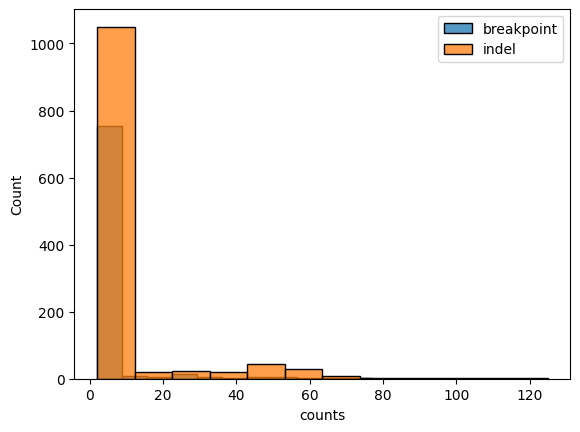

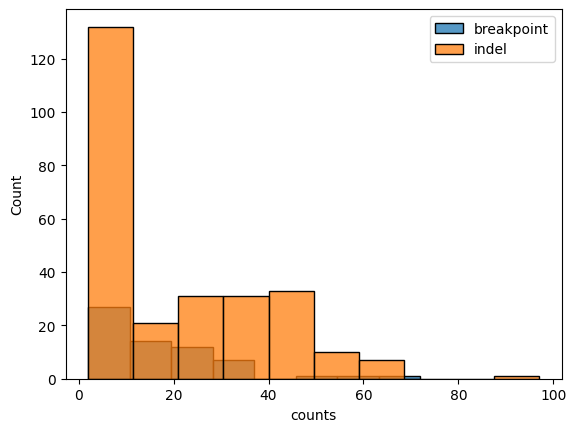

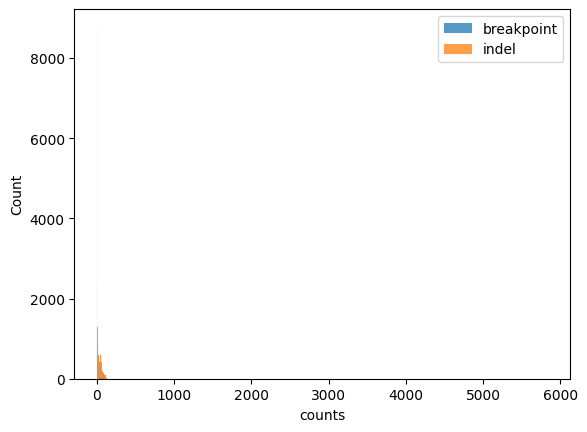

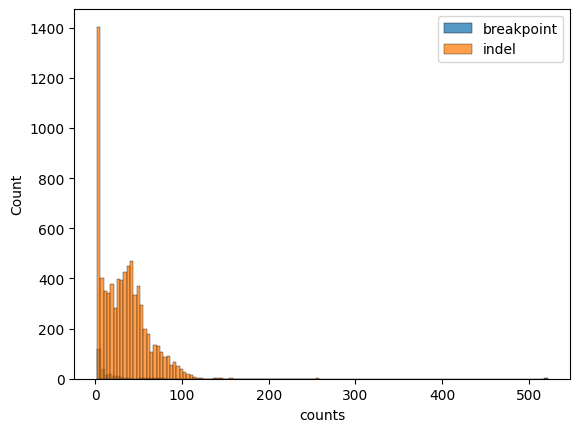

In [5]:
for test_bed_file in glob("chm13*harmonize/*COLO*harmonize*bed.gz"):
    test_bed = pd.read_table(test_bed_file)
    test_bed_bnd, test_bed_indel = remove_alt_path(test_bed)
    test_bed_clean = pd.concat([test_bed_bnd.loc[:, ['#chrom_contig1', 'start1', 'start2', 'counts', 'sv_type']], 
    test_bed_indel.loc[:, ['#chrom_contig1', 'start1', 'end1', 'counts', 'sv_type']].rename({"end1": "start2"}, axis='columns')], axis=0)
    #print(test_bed_clean.head())
    print(test_bed_clean.sv_type.value_counts())
    plt.figure()
    sns.histplot(test_bed_bnd['counts'], label='breakpoint')
    sns.histplot(test_bed_indel['counts'], label='indel')
    plt.legend()

In [14]:
glob("*harmonize/*COLO*harmonize*bed.gz")

['grch37linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch37linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'chm13graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'chm13graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch38graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch38graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'chm13linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'chm13linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch38linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch38linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch37graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch37graph_harmonize/COLO829_mapq5_m

In [50]:
truthset_dict = {"grch38": ['output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.PB.bed', 'output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.ONT.bed'],
                 "chm13":['output/truthset.colo829.out.chm13v2.crossmap.vcf.PB.bed', 'output/truthset.colo829.out.chm13v2.crossmap.vcf.ONT.bed'], 
                 "grch37": ['output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.PB.bed', 'output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.ONT.bed']}

In [51]:
truthset_dict

{'grch38': ['output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.PB.bed',
  'output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.ONT.bed'],
 'chm13': ['output/truthset.colo829.out.chm13v2.crossmap.vcf.PB.bed',
  'output/truthset.colo829.out.chm13v2.crossmap.vcf.ONT.bed'],
 'grch37': ['output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.PB.bed',
  'output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.ONT.bed']}

In [65]:
import os
colo_bench_results = []

for test_bed_file in glob("*harmonize/*COLO*harmonize*bed.gz"):
    print(test_bed_file)
    genome = os.path.dirname(test_bed_file).replace("linear_harmonize", "").replace("graph_harmonize", "")
    gold = truthset_dict[genome]

    test_bed = pd.read_table(test_bed_file)
    test_bed_bnd, test_bed_indel = remove_alt_path(test_bed)
    test_bed_clean = pd.concat([test_bed_bnd.loc[:, ['#chrom_contig1', 'start1', 'start2', 'counts', 'sv_type']], 
    test_bed_indel.loc[:, ['#chrom_contig1', 'start1', 'end1', 'counts', 'sv_type']].rename({"end1": "start2"}, axis='columns')], axis=0)
    #print(test_bed_clean.head())
    print(test_bed_clean.sv_type.value_counts())

    if 'ONT' in test_bed_file:
        gold = pd.read_table(gold[1], header=None)
        if 'grch37' not in test_bed_file:
            gold.iloc[:, 0] = gold.iloc[:, 0].map(lambda x: "chr%s" % x)
        gold = gold.iloc[:, [0, 1, 2, 4]]
        #print(gold.iloc[:, 2] - gold.iloc[:, 1])
    else:
        gold = pd.read_table(gold[0], header=None)
        if 'grch37' not in test_bed_file:
            gold.iloc[:, 0] = gold.iloc[:, 0].map(lambda x: "chr%s" % x)
        gold = gold.iloc[:, [0, 1, 2, 4]]
        #print(gold.iloc[:, 2] - gold.iloc[:, 1])

    start = test_bed_clean.apply(lambda x: x[2] if int(x[1]) > int(x[2]) else x[1], axis=1)
    end = test_bed_clean.apply(lambda x: x[1] if int(x[1]) > int(x[2]) else x[2], axis=1)
    test_bed_clean.loc[:, 'start1'] = start
    test_bed_clean.loc[:, 'start2'] = end
    
    test_bed_clean = test_bed_clean.loc[test_bed_clean.start2.astype(int) - test_bed_clean.start1.astype(int) >= 50, :]
    our_sv = pybedtools.BedTool.from_dataframe(test_bed_clean)
    our_sv_df = our_sv.sort().merge(d=200, c=4, o='sum').to_dataframe()
    our_sv_filter = pybedtools.BedTool.from_dataframe(our_sv_df.loc[our_sv_df.iloc[:, -1] >= 10, :])
    gold_sv = pybedtools.BedTool.from_dataframe(gold)
    colo_bench_results.append([test_bed_file, our_sv_filter.sort().merge(d=200).count(), gold_sv.sort().merge(d=200).count(), gold_sv.sort().merge(d=200).intersect(our_sv_filter.sort().merge(d=200), wa=True, u=True).count(), our_sv_filter.sort().merge().intersect(gold_sv.sort().merge(d=200), wa=True, u=True).count()])
    #colo_bench_results.append([test_bed_file, our_sv.sort().merge(d=200).count(), gold_sv.sort().merge(d=200).count(), gold_sv.sort().merge().intersect(our_sv, wa=True, u=True).count(), gold_sv.intersect(our_sv, wa=True, u=True).count(), our_sv.sort().merge().intersect(gold_sv, wa=True, u=True).count()])

grch37linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1261620617.py:9: DtypeWarning: Columns (2,6,7,8,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    48910
bnd       2362
Name: sv_type, dtype: int64
grch37linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1261620617.py:9: DtypeWarning: Columns (2,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    20664
bnd        845
Name: sv_type, dtype: int64
chm13graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1261620617.py:9: DtypeWarning: Columns (2,6,7,8,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    1203
bnd       800
Name: sv_type, dtype: int64
chm13graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    266
bnd       63
Name: sv_type, dtype: int64
grch38graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1261620617.py:9: DtypeWarning: Columns (2,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    1844
bnd       964
Name: sv_type, dtype: int64
grch38graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    418
bnd      107
Name: sv_type, dtype: int64
chm13linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1261620617.py:9: DtypeWarning: Columns (2,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    24825
bnd       1117
Name: sv_type, dtype: int64
chm13linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1261620617.py:9: DtypeWarning: Columns (2,6,7,8,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    7598
bnd       235
Name: sv_type, dtype: int64
grch38linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1261620617.py:9: DtypeWarning: Columns (2,6,7,8,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    38908
bnd       1589
Name: sv_type, dtype: int64
grch38linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1261620617.py:9: DtypeWarning: Columns (2,6,7,8,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    15092
bnd        443
Name: sv_type, dtype: int64
grch37graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/1261620617.py:9: DtypeWarning: Columns (2,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    3582
bnd      1710
Name: sv_type, dtype: int64
grch37graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_34081/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    669
bnd      508
Name: sv_type, dtype: int64


In [67]:
final_table = pd.DataFrame(colo_bench_results)

final_table.columns = ['dataset_assembly', 'merged_our_sv_filter', 'merged_truthset', 'merged_true_positive_hits', 'all_hits']

In [68]:
final_table


,dataset_assembly,merged_our_sv_filter,merged_truthset,merged_true_positive_hits,all_hits
0,grch37linear_harmonize/COLO829_ONT_mapq5_mlen5...,3984,29,29,63
1,grch37linear_harmonize/COLO829_mapq5_mlen50_su...,5494,24,22,44
2,chm13graph_harmonize/COLO829_ONT_mapq5_mlen50_...,47,29,28,15
3,chm13graph_harmonize/COLO829_mapq5_mlen50_supp...,101,23,20,20
4,grch38graph_harmonize/COLO829_ONT_mapq5_mlen50...,166,30,29,16
5,grch38graph_harmonize/COLO829_mapq5_mlen50_sup...,136,24,19,19
6,chm13linear_harmonize/COLO829_ONT_mapq5_mlen50...,2573,29,29,57
7,chm13linear_harmonize/COLO829_mapq5_mlen50_sup...,2634,23,21,36
8,grch38linear_harmonize/COLO829_ONT_mapq5_mlen5...,3552,30,30,28
9,grch38linear_harmonize/COLO829_mapq5_mlen50_su...,3934,24,22,42
